In [1]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.db as db
import lsst.sims.maf.metricBundles as mmb
import lsst.sims.maf.utils as utils

In [3]:
def setupSlicer(orbitFile, Hrange, obsFile=None):
    # Read the orbit file and set the H values for the slicer.
    slicer = slicers.MoObjSlicer()
    slicer.readOrbits(orbitFile, Hrange=Hrange)
    if obsFile is not None:
        slicer.readObs(obsFile)
    return slicer

In [4]:
def setupBundle(slicer, metadata, nyr, snrLimit=10):
    # basically any sql-like 'where' clause (actually interpreted by pandas)
    constraint = 'night <= %d' %(nyr * 365)
    # metadata to attach to this particular metric/constraint combo
    md = metadata + ' year %d' % nyr
    plotDict = {'nxbins': 200, 'nybins': 200,
                'title': '%s: %s' % (runName, md)}
    plotFuncs = [plots.MetricVsH()]
    metric = metrics.ColorDeterminationMetric(nPairs=1, nHours=2, snrLimit=snrLimit, bOne='g', bTwo='r')
    bundle = mmb.MoMetricBundle(metric, slicer, constraint,
                                runName=runName, metadata=md,
                                plotDict=plotDict, plotFuncs=plotFuncs)
    return bundle

In [5]:
def setupStackers(trailingLossCol):
    # trailingLossCol = 'dmagDetect' (PSF detection) or 'dmagTrail' (intrinsic SNR loss due to trailing)
    magLimitStacker = stackers.MagLimitStacker(lossCol=trailingLossCol)
    allStackers = stackers.AllMoStackers(magLimitStacker=magLimitStacker)
    return allStackers

In [6]:
opsim = 'minion_1016'
orbitFile = 'orbits/tnos_2k.des'
obsFile = os.path.join(opsim, opsim + '__tnos_2k_obs.txt')
#obsFile = os.path.join(opsim, opsim + '_tmp_obs.txt')
Hrange = np.arange(5, 11, .5)

In [7]:
runName = opsim
nyr = 10
metadata = 'TNO'

In [10]:
slicer = setupSlicer(orbitFile, Hrange, obsFile=obsFile)

In [13]:
bundle_gr = setupBundle(slicer, metadata + ' g-r', nyr, 10)

In [14]:
allstackers_detect = setupStackers('dmagDetect')

In [15]:
bg = mmb.MoMetricBundleGroup({0:bundle_gr}, outDir='colors', resultsDb=None, 
                             allStackers=allstackers_detect)
bg.runAll()
bg.writeAll()
bg.summaryAll()

Calculated all metrics.
Saving metric bundles.


{'MetricVsH': 1}

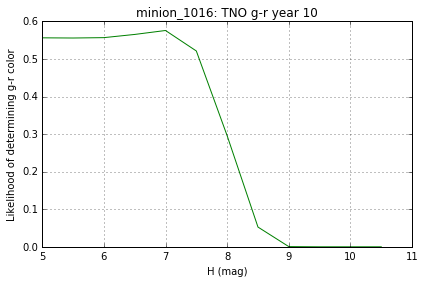

In [34]:
# simple single-quantity plot.
plotDict = {'color':'g', 'ylabel':'Likelihood of determining g-r color'}
bundle_gr.setPlotDict(plotDict)
bundle_gr.plot()

1

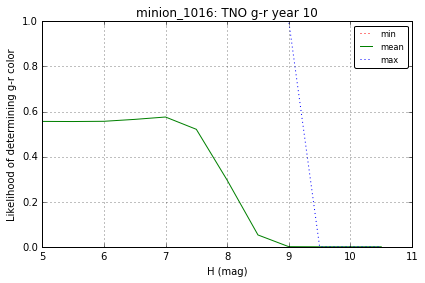

In [30]:
# More complicated plot
ph = plots.PlotHandler()
bundles = []
plotDicts = []
for val in ['min', 'mean', 'max']:
    if val == 'min':
        plotDict = {'color':'r', 'linestyle':':', 'npReduce':np.min, 'label':val}
    elif val == 'max':
        plotDict = {'color':'b', 'linestyle':':', 'npReduce':np.max, 'label':val}
    elif val == 'mean':
        plotDict = {'color':'g', 'linestyle':'-', 'npReduce':np.mean, 'label':val}
    elif val == 'median':
        plotDict = {'color':'b', 'linestyle':'-', 'npReduce':np.median, 'label':val}
    plotDict['ylabel'] = 'Likelihood of determining g-r color'
    bundles.append(bundle_gr)
    plotDicts.append(plotDict)
ph.setMetricBundles(bundles)
ph.plot(plotFunc=plots.MetricVsH(), plotDicts=plotDicts)